# Logistic Regression: Beyond Linear Regression

In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression

**Classification techniques** are an essential part of machine learning and data mining applications. Approximately 70% of problems in Data Science are classification problems. There are lots of classification algorithms that are available, but logistic regression is exceedingly common and useful. We shall focus on binary classification problems, to which logistic regression most immediately applies. Other classification problems handle the cases where multiple classes are present in the target variable, though logistic regression can be extended to cover this sort of case as well. The iris dataset is a very famous example of multi-class classification.

**Logistic Regression** is one of the most simple and commonly used Machine Learning algorithms for two-class classification. It is easy to implement and can be used as the baseline for any binary classification problem. Its basic fundamental concepts are also constructive in deep learning. Logistic regression describes and estimates the relationship between one dependent binary variable and independent variables.

## Agenda

1. Motivate the need to move beyond linear regression conceptually
2. Attempt to use linear regression for classification
3. Give a brief overview of probability, odds, e, log, and log-odds
4. Explain the form of logistic regression
5. Explain how to interpret logistic regression coefficients
6. Consider different generalizations of linear regression for different scenarios

## Beyond Linear Regression

Linear regressions have [limitations](https://en.wikipedia.org/wiki/Generalized_linear_model).

As it stands, the algorithm could generate a prediction *anywhere on the real number line*. This *may* be realistic, like if I'm predicting national surpluses/debts.

But what if I'm predicting values of a variable that doesn't take, say, negative values, like temperature in Kelvin?

What if I'm predicting values of a variable that takes only integer values, like the number of mouseclicks on my killer ds blog per minute?

What if I'm predicting probabilities? Or something Boolean / Bernoullian?

What if the shape of my errors changes as a function of the dependent variable?

Am I stuck using linear regression? There's got to be a better way!

## Predicting a Categorical Response

Here we have a dataset about glass. Information [here](https://archive.ics.uci.edu/ml/datasets/glass+identification).

In [42]:
# glass identification dataset

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
col_names = ['id','ri','na','mg','al','si','k','ca','ba','fe','glass_type']
glass = pd.read_csv(url, names=col_names, index_col='id')
glass.sort_values('al', inplace=True)
glass.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type
id,,,,,,,,,,
22,1.51966,14.77,3.75,0.29,72.02,0.03,9.00,0.0,0.00,1
185,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.0,0.00,6
40,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1
51,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.0,0.16,1


In [43]:
# examine glass_type

glass.glass_type.value_counts().sort_index()

1    70
2    76
3    17
5    13
6     9
7    29
Name: glass_type, dtype: int64

In [44]:
# types 1, 2, 3 are window glass - as 0
# types 5, 6, 7 are household glass - as 1

glass['household'] = glass.glass_type.map({1:0, 2:0, 3:0, 5:1, 6:1, 7:1})
glass.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,household
id,,,,,,,,,,,
22,1.51966,14.77,3.75,0.29,72.02,0.03,9.00,0.0,0.00,1,0
185,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.0,0.00,6,1
40,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1,0
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1,0
51,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.0,0.16,1,0


Let's change our task, so that we're predicting **household** using **al**. Let's visualize the relationship to figure out how to do this:

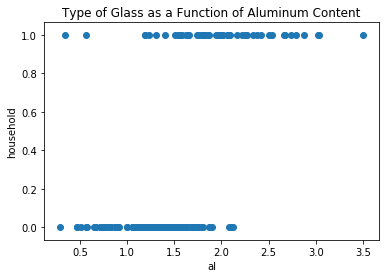

In [45]:
fig, ax = plt.subplots()
ax.scatter(glass.al, glass.household)
ax.set_xlabel('al')
ax.set_ylabel('household')
ax.set_title('Type of Glass as a Function of Aluminum Content');

Let's draw a **regression line**, like we did before:

In [46]:
# fit a linear regression model and store the predictions

linreg = LinearRegression()
feature_cols = ['al']
X = glass[feature_cols]
y = glass.household
linreg.fit(X, y)
glass['household_pred'] = linreg.predict(X)

/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


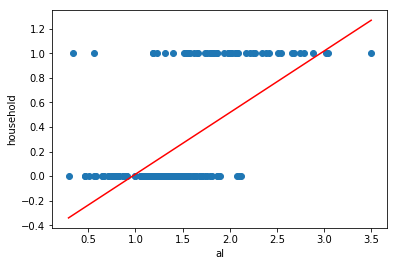

In [47]:
# scatter plot that includes the regression line

fig, ax = plt.subplots()
ax.scatter(glass.al, glass.household)
ax.plot(glass.al, glass.household_pred, color='red')
ax.set_xlabel('al')
ax.set_ylabel('household');

### What are some issues with the graph above?

___

If **al=3**, what class do we predict for household? 

If **al=1.5**, what class do we predict for household? 

We predict the 0 class for **lower** values of al, and the 1 class for **higher** values of al. What's our cutoff value? Around **al=2**, because that's where the linear regression line crosses the midpoint between predicting class 0 and class 1.

Therefore, we'll say that if **household_pred >= 0.5**, we predict a class of **1**, else we predict a class of **0**.

In [50]:
# transform household_pred to 1 or 0

glass['household_pred_class'] = np.where(glass.household_pred >= 0.5, 1, 0)
glass.head()

,ri,na,mg,al,si,k,ca,ba,fe,glass_type,household,household_pred,household_pred_class
id,,,,,,,,,,,,,
22,1.51966,14.77,3.75,0.29,72.02,0.03,9.00,0.0,0.00,1,0,-0.340495,0
185,1.51115,17.38,0.00,0.34,75.41,0.00,6.65,0.0,0.00,6,1,-0.315436,0
40,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1,0,-0.250283,0
39,1.52213,14.21,3.82,0.47,71.77,0.11,9.57,0.0,0.00,1,0,-0.250283,0
51,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.0,0.16,1,0,-0.230236,0


/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


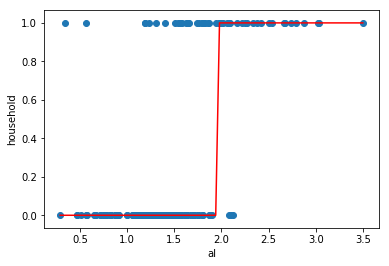

In [51]:
# plot the class predictions

fig, ax = plt.subplots()
ax.scatter(glass.al, glass.household)
ax.plot(glass.al, glass.household_pred_class, color='red')
ax.set_xlabel('al')
ax.set_ylabel('household');

## Logistic Regression

Logistic regression can do what we just did.

The strategy now is to *generalize* the notion of linear regression; linear regression as we've known it will become a special case. In particular, we'll keep the idea of the regression best-fit line, but now **we'll allow the model to make predictions through some (non-trivial) transformation of the linear predictor**.

Let's say we've constructed our best-fit line, i.e. our linear predictor, $\hat{L} = \beta_0 + \beta_1x_1 + ... + \beta_nx_n$.

Consider the following transformation: <br/>
$\large\hat{y} = \Large\frac{1}{1 + e^{-\hat{L}}} \large= \Large\frac{1}{1 + e^{-(\beta_0 + ... + \beta_nx_n)}}$. This is called the **sigmoid function**.

We're imagining that $\hat{L}$ can take any values between $-\infty$ and $\infty$.

$\large\rightarrow$ But what values can $\hat{y}$ take? What does this function even look like?

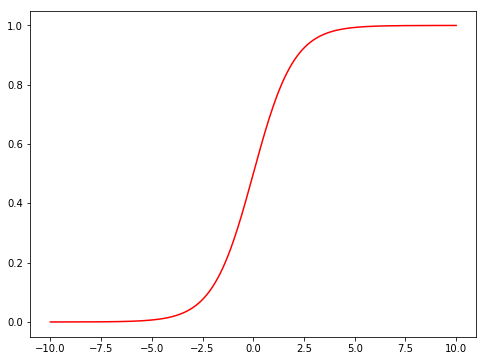

In [52]:
# Let's plot this function here:

X = np.linspace(-10, 10, 300)
Y = 1 / (1 + np.exp(-X))

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(X, Y, 'r');

## Interpretation

This function squeezes our predictions between 0 and 1. And that's why it's so useful for **binary classification problems**.

Suppose I'm building a model to predict whether a plant is poisonous or not, based perhaps on certain biological features of its leaves. I'll let '1' indicate a poisonous plant and '0' indicate a non-poisonous plant.

Now I'm forcing my predictions to be between 0 and 1, so suppose for test plant $P$ I get some value like 0.19.

I can naturally understand this as **the probability that $P$ is poisonous**.

If I truly want a binary prediction, I can simply round my score appropriately.

How do we fit a line to our dependent variable if its values are already stored as probabilities? We can use the inverse of the sigmoid function, and just set our regression equation equal to that. The inverse of the sigmoid function is called the **logit function**, and it looks like this:

$\large f(y) = \ln\left(\frac{y}{1 - y}\right)$. Notice that the domain of this function is $(0, 1)$.

$\hspace{110mm}$(Quick proof that logit and sigmoid are inverse functions:

$\hspace{170mm}x = \frac{1}{1 + e^{-y}}$; <br/>
$\hspace{170mm}$so $1 + e^{-y} = \frac{1}{x}$; <br/>
$\hspace{170mm}$so $e^{-y} = \frac{1 - x}{x}$; <br/>
$\hspace{170mm}$so $-y = \ln\left(\frac{1 - x}{x}\right)$; <br/>
$\hspace{170mm}$so $y = \ln\left(\frac{x}{1 - x}\right)$.)

Our regression equation will now look like this:

$\large\ln\left(\frac{y}{1 - y}\right) = \beta_0 + \beta_1x_1 + ... + \beta_nx_n$.

This equation is used for a **logistic regression**. Note that it is now not the target variable itself that is modeled as varying linearly with the predictor(s) but rather the values of this logit function of the target that are so represented. This is the sense in which we have a more generalized notion of a linear model.

This function whose values are modeled as varying linearly is in general called the **link function**.

## Odds

There are other ways to squeeze the results of a linear regression into the set (0, 1).

But the ratio $\frac{p}{1-p}$ represents the *odds* of some event, where $p$ is the probability of the event.

$$probability = \frac {one\ outcome} {all\ outcomes}$$

$$odds = \frac {one\ outcome} {all\ other\ outcomes}$$

Examples:

- Dice roll of 1: probability = 1/6, odds = 1/5
- Even dice roll: probability = 3/6, odds = 3/3 = 1
- Dice roll less than 5: probability = 4/6, odds = 4/2 = 2

$$odds = \frac {probability} {1 - probability}$$

$$probability = \frac {odds} {1 + odds}$$

And so the logit function represents the **log-odds** of success (y=1).

## `sklearn.linear_model.LogisticRegression()`

In general, we should always scale our data when using this class. Scaling is always important for models that include regularization, and scikit-learn's `LogisticRegression()` objects have regularization by default.

Here we've forgone the scaling since we only have a single predictor.

In [57]:
# fit a logistic regression model and store the class predictions

logreg = LogisticRegression(random_state=42)   # We need always to scale data! make on the same scale 
# Smaller C - more reguralization
feature_cols = ['al']
X = glass[feature_cols]
y = glass.household
logreg.fit(X, y)
glass['household_pred_class'] = logreg.predict(X)

In [59]:
y

id
22     0
185    1
40     0
39     0
51     0
      ..
193    1
210    1
173    1
172    1
164    1
Name: household, Length: 214, dtype: int64

In [61]:
glass.household_pred_class

id
22     0
185    0
40     0
39     0
51     0
      ..
193    1
210    1
173    1
172    1
164    1
Name: household_pred_class, Length: 214, dtype: int64

/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


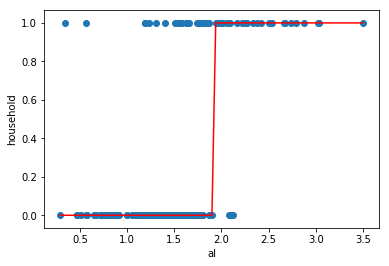

In [58]:
# plot the class predictions

fig, ax = plt.subplots()
ax.scatter(glass.al, glass.household)
ax.plot(glass.al, glass.household_pred_class, color='red')
ax.set_xlabel('al')
ax.set_ylabel('household');

## `.predict()` vs. `.predict_proba()`

In [28]:
glass.al

id
22     0.29
185    0.34
40     0.47
39     0.47
51     0.51
       ... 
193    2.79
210    2.88
173    3.02
172    3.04
164    3.50
Name: al, Length: 214, dtype: float64

In [29]:
# examine some example predictions

print(logreg.predict(glass['al'][22].reshape(1, -1)))
print(logreg.predict(glass['al'][185].reshape(1, -1)))
print(logreg.predict(glass['al'][164].reshape(1, -1)))
print('\n')
print(logreg.predict_proba(glass['al'][22].reshape(1, -1))[0])
print(logreg.predict_proba(glass['al'][185].reshape(1, -1))[0])
print(logreg.predict_proba(glass['al'][164].reshape(1, -1))[0])
first_row = glass['al'][22].reshape(1, -1)

[0]
[0]
[1]


[0.9939759 0.0060241]
[0.99296771 0.00703229]
[0.00743731 0.99256269]


## Cost Functions and Solutions to the Optimization Problem

No one has yet found a closed-form solution to the optimization problem presented by logistic regression. But even if one exists, the computation would no doubt be so complex that we'd be better off using some sort of approximation method instead.

Various versions of gradient descent or coordinate descent (this is like gradient descent but it focuses only on one parameter at a time) have been used. The scikit-learn class expects the user to specify the solver to be used in calculating the coefficients.

**Question**: What are we using this approximation method *on*? With linear regression we could sensibly calculate a residual sum of squares, but that doesn't seem to apply any more.

**Answer**: When solving for the optimal coefficients of a logistic regression model, **Log-Loss** is the cost function that is used. Roughly, we want to measure how far off our predictions are. (That part is still the same.) But now we'll be comparing our predictions to 0's and 1's. Predictions near 0 for actual negatives and near 1 for actual positives should count far less to our loss function than predictions near 1 for actual negatives and near 0 for actual positives.

**More resources**:

https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-ii-d20a239cde11

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

http://wiki.fast.ai/index.php/Log_Loss

In [30]:
# store the predicted probabilites of class 1

glass['household_pred_prob'] = logreg.predict_proba(X)[:, 1]

/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/ivan/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


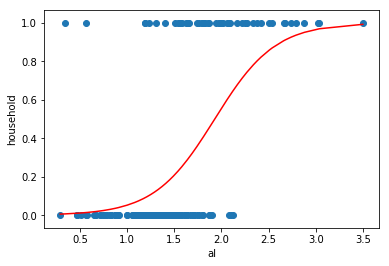

In [31]:
# plot the predicted probabilities

fig, ax = plt.subplots()
ax.scatter(glass.al, glass.household)
ax.plot(glass.al, glass.household_pred_prob, color='red')
ax.set_xlabel('al')
ax.set_ylabel('household');

The first column indicates the predicted probability of **class 0**, and the second column indicates the predicted probability of **class 1**.

## Interpreting Logistic Regression Coefficients

In [32]:
logreg.coef_

array([[3.11517927]])

How do we interpret the coefficients of a logistic regression? For a linear regression, the situaton was like this:

- Linear Regression: We construct the best-fit line and get a set of coefficients. Suppose $\beta_1 = k$. In that case we would expect a 1-unit change in $x_1$ to produce a $k$-unit change in $y$.

- Logistic Regression: We find the coefficients of the best-fit line by some approximation method. Suppose $\beta_1 = k$. In that case we would expect a 1-unit change in $x_1$ to produce a $k$-unit change (not in $y$ but) in $ln\left(\frac{y}{1-y}\right)$.

We have:

$\ln\left(\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)}\right) = \ln\left(\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}\right) + k$.

Exponentiating both sides:

$\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)} = e^{\ln\left(\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}\right) + k}$ <br/><br/> $\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)}= e^{\ln\left(\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}\right)}\cdot e^k$ <br/><br/> $\frac{y(x_1+1, ... , x_n)}{1-y(x_1+1, ... , x_n)}= e^k\cdot\frac{y(x_1, ... , x_n)}{1-y(x_1, ... , x_n)}$

That is, the odds ratio at $x_1+1$ has increased by a factor of $e^k$ relative to the odds ratio at $x_1$.

For more on interpretation, see [this page](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/binary-logistic-regression/interpret-the-results/all-statistics-and-graphs/coefficients/).

In [33]:
# examine the intercept

logreg.intercept_

array([-6.00934605])

**Interpretation:** For an 'al' value of 0, the log-odds of 'household' is -6.01.

In [34]:
# convert log-odds to probability

logodds = logreg.intercept_
odds = np.exp(logodds)
prob = odds / (1 + odds)
prob

array([0.00244968])

In [35]:
# examine the coefficient for al

list(zip(feature_cols, logreg.coef_[0]))

[('al', 3.1151792681570165)]

**Interpretation:** A 1 unit increase in 'al' is associated with a 3.12 unit increase in the log-odds of 'household'.

In [36]:
# compute predicted log-odds for al=2 using the equation

logodds = logreg.intercept_ + logreg.coef_[0] * 2
logodds

array([0.22101248])

In [37]:
# convert log-odds to odds

odds = np.exp(logodds)
odds

array([1.247339])

In [38]:
# convert odds to probability

prob = odds / (1 + odds)
prob

array([0.5550293])

In [39]:
# compute predicted probability for al=2 using the predict_proba method

logreg.predict_proba(np.array([2]).reshape(1, 1))[:, 1]

array([0.5550293])

## More Generalizations: Other Link Functions, Other Models

Logistic regression's link function is the logit function, but different sorts of models use different link functions.

[Wikipedia](https://en.wikipedia.org/wiki/Generalized_linear_model#Link_function) has a nice table of generalized linear model types and their associated link functions.